In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as BS
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep
from scipy.stats import probplot, zscore
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Инициализация chrome webdriver
driver = webdriver.Chrome()
data = []

try:
    for i in range(1, 11):
        # Загрузка страницы
        driver.get("https://www.kinopoisk.ru/lists/movies/top500/?page=" + str(i))
        # Ждём, пока загрузится заголовок при динамическом исполнении JS
        driver.implicitly_wait(10)
        sleep(5)
        # Selenium может извлечь динамически загруженные элементы
        soup = BS(driver.page_source, "html.parser")
        films = soup.find_all(class_='styles_upper__j8BIs')
        for film in films:
            name = film.find(class_="styles_mainTitle__IFQyZ styles_activeMovieTittle__kJdJj").text
            rating = film.find(class_='styles_kinopoiskValue__nkZEC').text
            rating_count = film.find('span', class_='styles_kinopoiskCount__PT7ZX').text
            desc = film.find(class_='desktop-list-main-info_additionalInfo__Hqzof').text
            date_time = film.find(class_='desktop-list-main-info_secondaryText__M_aus').text
            link = "https://www.kinopoisk.ru" + film.find('a', class_="base-movie-main-info_link__YwtP1").get('href')
            data.append((name, rating, rating_count, desc, date_time, link))
finally:
    print(data)
    

driver.quit()


[('1+1', '8.3', '566 951', 'Франция • драма\xa0\xa0Режиссёр: Оливье Накаш', ', 2011, 1 ч 52 мин', 'https://www.kinopoisk.ru/film/535341/'), ('Интерстеллар', '8.2', '103 371', 'США • фантастика\xa0\xa0Режиссёр: Кристофер Нолан', ', 2014, 2 ч 49 мин', 'https://www.kinopoisk.ru/film/258687/'), ('Побег из Шоушенка', '8.2', '84 518', 'США • драма\xa0\xa0Режиссёр: Фрэнк Дарабонт', ', 1994, 2 ч 22 мин', 'https://www.kinopoisk.ru/film/326/'), ('Зеленая миля', '8.1', '87 483', 'США • драма\xa0\xa0Режиссёр: Фрэнк Дарабонт', ', 1999, 3 ч 9 мин', 'https://www.kinopoisk.ru/film/435/'), ('Бойцовский клуб', '8.1', '187 173', 'США • триллер\xa0\xa0Режиссёр: Дэвид Финчер', ', 1999, 2 ч 19 мин', 'https://www.kinopoisk.ru/film/361/'), ('Остров проклятых', '8.1', '212 428', 'США • триллер\xa0\xa0Режиссёр: Мартин Скорсезе', ', 2009, 2 ч 18 мин', 'https://www.kinopoisk.ru/film/397667/'), ('Форрест Гамп', '8.1', '74 188', 'США • драма\xa0\xa0Режиссёр: Роберт Земекис', ', 1994, 2 ч 22 мин', 'https://www.kinop

In [3]:
df = pd.DataFrame(data, columns=['Name', 'Rating', 'Rating count', 'Description', 'Year_Time', 'Link'])

In [4]:
df['Country'] = df['Description'].str.split('•').apply(lambda x : x[0])
df['Genre'] = df['Description'].str.split('•').apply(lambda x : x[1].split()[0])
df['Director'] = df['Description'].str.split('•').apply(lambda x : x[1].split('Режиссёр:')[1])
df['Year'] = df['Year_Time'].str.split(',').apply(lambda x : x[-2])
df['Time'] = df['Year_Time'].str.split(',').apply(lambda x : x[-1])


In [5]:
df['Rating'] = df['Rating'].astype('float')
df['Rating count'] = df['Rating count'].str.replace(' ', '').astype('int')
df['Year'] = df['Year'].astype('int')
df['Genre'] = df['Genre'].astype('category')

def convert_time(t):
    res = 0
    if 'ч' in t:
        res += int(t.split('ч')[0]) * 60
    if 'мин' in t:
        res += int(t.split('мин')[0].split()[-1])
    return res
        
df['Time'] = df['Time'].apply(convert_time)

In [6]:
df.drop(columns=['Description', 'Year_Time'], inplace=True)

In [7]:
df.rename(columns={'Time': 'Time (min)'}, inplace=True)

In [8]:
df

,Name,Rating,Rating count,Link,Country,Genre,Director,Year,Time (min)
0,1+1,8.3,566951,https://www.kinopoisk.ru/film/535341/,Франция,драма,Оливье Накаш,2011,112
1,Интерстеллар,8.2,103371,https://www.kinopoisk.ru/film/258687/,США,фантастика,Кристофер Нолан,2014,169
2,Побег из Шоушенка,8.2,84518,https://www.kinopoisk.ru/film/326/,США,драма,Фрэнк Дарабонт,1994,142
3,Зеленая миля,8.1,87483,https://www.kinopoisk.ru/film/435/,США,драма,Фрэнк Дарабонт,1999,189
4,Бойцовский клуб,8.1,187173,https://www.kinopoisk.ru/film/361/,США,триллер,Дэвид Финчер,1999,139
...,...,...,...,...,...,...,...,...,...
495,"Руслан и Людмила. Больше, чем сказка",6.9,120291,https://www.kinopoisk.ru/film/5356063/,Россия,мультфильм,Алексей Цицилин,2023,95
496,Первый день моей жизни,6.9,74758,https://www.kinopoisk.ru/film/1138971/,Италия,фэнтези,Паоло Дженовезе,2023,121
497,Невероятная жизнь Уолтера Митти,6.9,12126,https://www.kinopoisk.ru/film/6034/,США,комедия,Бен Стиллер,2013,114
498,Бесстрашный,6.9,24744,https://www.kinopoisk.ru/film/102161/,Китай,боевик,Ронни Юй,2006,104


In [9]:
df.describe()

,Rating,Rating count,Year,Time (min)
count,500.000000,500.000000,500.000000,500.000000
mean,7.225400,58944.490000,2003.346000,121.842000
std,0.249679,64238.295829,14.636487,24.705176
min,6.900000,5350.000000,1956.000000,46.000000
25%,7.000000,23062.500000,1997.000000,103.750000
50%,7.200000,37817.500000,2006.000000,120.000000
75%,7.300000,70549.750000,2014.000000,136.000000
max,8.300000,566951.000000,2024.000000,202.000000


In [10]:
# Узнаем сколько фильмов по странам
df['Country'].value_counts()

США                268
СССР                45
Великобритания      45
Россия              35
Франция             18
Япония              17
Германия            12
Новая Зеландия       8
Италия               8
Корея Южная          7
Испания              6
Канада               5
Австралия            4
Дания                4
Китай                3
Швеция               2
Гонконг              2
Ирландия             2
Беларусь             1
Мексика              1
Бразилия             1
Бельгия              1
Аргентина            1
Индия                1
ЮАР                  1
Норвегия             1
Казахстан            1
Name: Country, dtype: int64

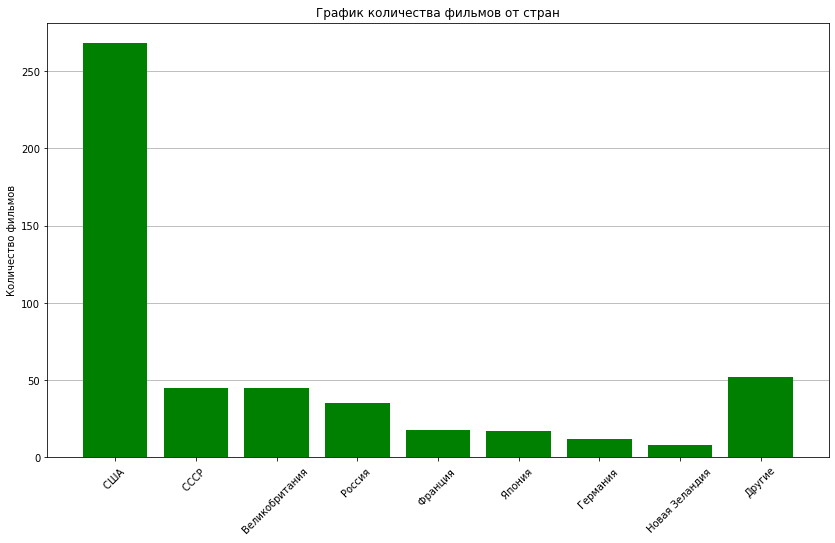

In [11]:
# Изобразим графически для наглядности

others = pd.Series(df['Country'].value_counts()[8:].sum(), index=['Другие'])
countries = pd.concat([df['Country'].value_counts()[:8], others])

plt.figure(figsize=(14, 8))
plt.grid(axis='y', zorder=0)
plt.bar(countries.index, countries, width=0.8, color='green', zorder=3)
plt.xticks(rotation=45)
plt.ylabel('Количество фильмов')
plt.title('График количества фильмов от стран')
plt.show()

In [12]:
# как видно довольно много фильмов из США

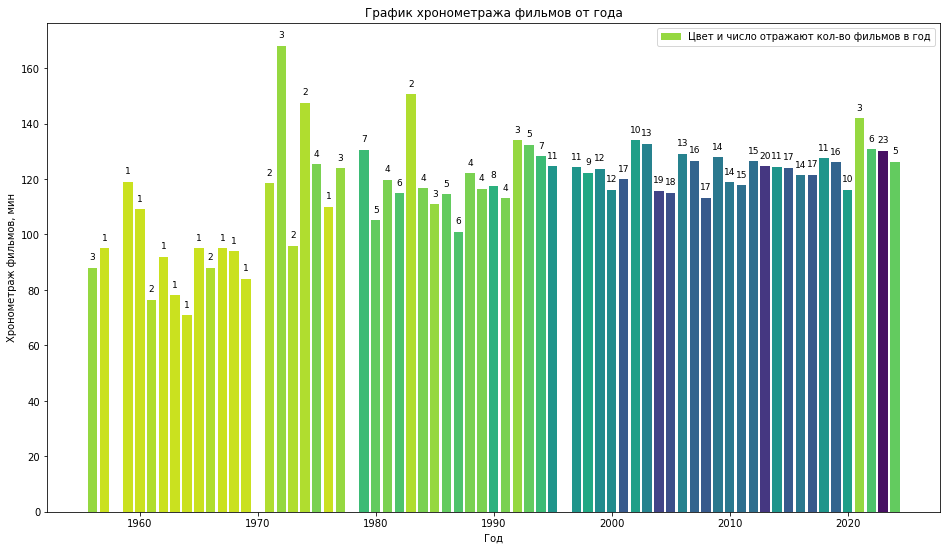

In [13]:

palette = sns.color_palette("viridis", 24)[::-1]

temp_df = df.groupby(['Year'])['Time (min)'].agg(['mean', 'count'])
fig, ax = plt.subplots(figsize=(16,9))
color = [palette[i] for i in temp_df['count']]

b = ax.bar(temp_df.index, temp_df['mean'], color=color, label='Цвет и число отражают кол-во фильмов в год')
ax.bar_label(b, labels=temp_df['count'],
             padding=6, fontsize=9)

ax.set_xlabel('Год')
ax.set_ylabel('Хронометраж фильмов, мин')
ax.set_title('График хронометража фильмов от года')
ax.legend()

plt.show()

In [14]:
# По количеству данных по годам можно условно разделить на три группы 1956 - 1977, 1979 - 1992, 1993 - 2024

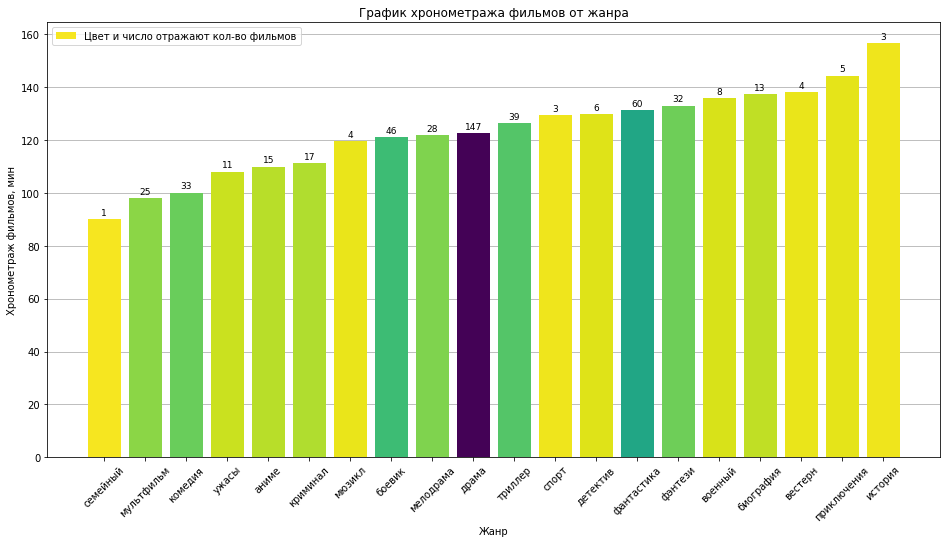

In [15]:
temp_df = df.groupby(['Genre'])['Time (min)'].agg(['mean', 'count']).sort_values(by='mean')
palette = sns.color_palette("viridis", temp_df['count'].max() + 1)[::-1]

fig, ax = plt.subplots(figsize=(16,8))
color = [palette[i] for i in temp_df['count']]


b = ax.bar(temp_df.index, temp_df['mean'], color=color, label='Цвет и число отражают кол-во фильмов', zorder=3)
ax.bar_label(b, labels=temp_df['count'],
             padding=2, fontsize=9)
plt.xticks(rotation=45)
# ax.set_xticklabels(temp_df.index, rotation=45)
ax.set_xlabel('Жанр')


ax.set_ylabel('Хронометраж фильмов, мин')
ax.set_title('График хронометража фильмов от жанра')
ax.legend(loc= 'upper left')
ax.grid(axis='y', zorder=0)
plt.show()

In [16]:
df.to_csv('kinopoist_top_500.csv', index=False)

In [17]:
# Рассмотрим подробнее жанры в которых больше 30 фильмов

In [18]:
temp = df['Genre'].value_counts()
popular_genres = temp[temp >= 30].index.to_list()
df_pop = df[df['Genre'].isin(popular_genres)].reset_index(drop=True)
df_pop['Genre'] = df_pop['Genre'].cat.remove_unused_categories()

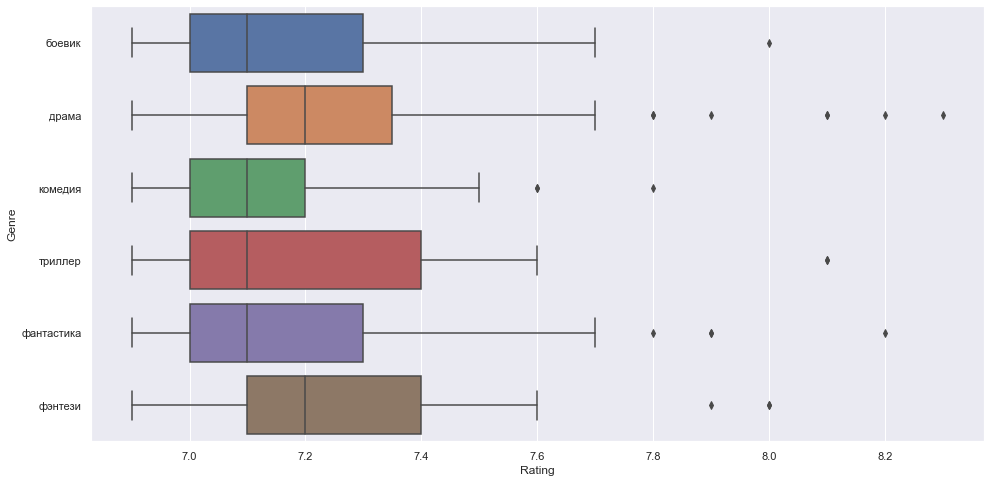

In [19]:
sns.set_theme(rc={'figure.figsize':(16, 8)})
sns.boxplot(data=df_pop, x='Rating', y='Genre')
plt.show()

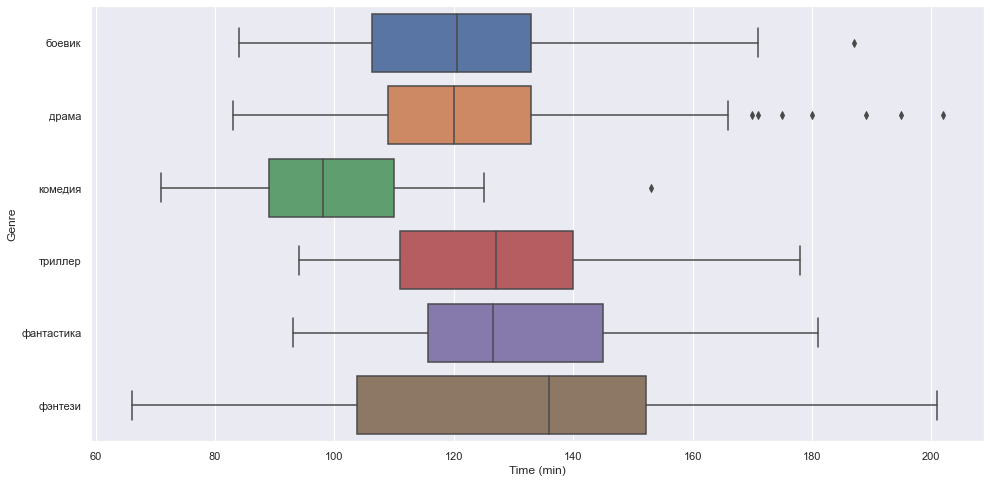

In [20]:
sns.set_theme(rc={'figure.figsize':(16, 8)})
sns.boxplot(data=df_pop, x='Time (min)', y='Genre')
plt.show()

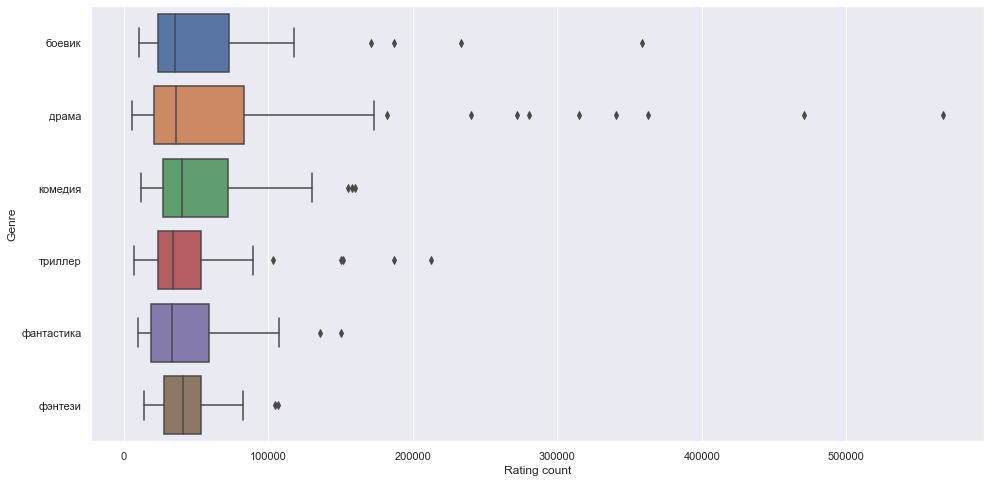

In [21]:
sns.set_theme(rc={'figure.figsize':(16, 8)})
sns.boxplot(data=df_pop, x='Rating count', y='Genre')
plt.show()

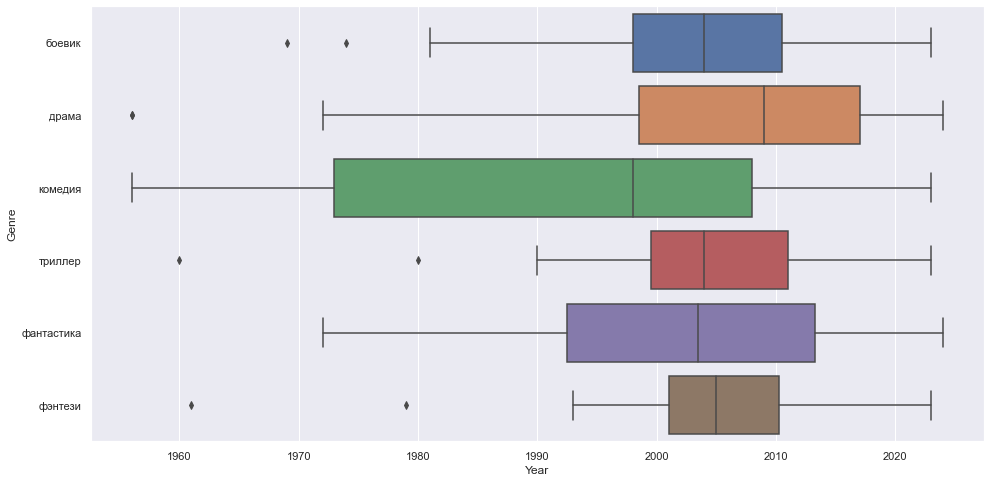

In [22]:
sns.set_theme(rc={'figure.figsize':(16, 8)})
sns.boxplot(data=df_pop, x='Year', y='Genre')
plt.show()

In [23]:
# Проверим на нормальность наши данные 

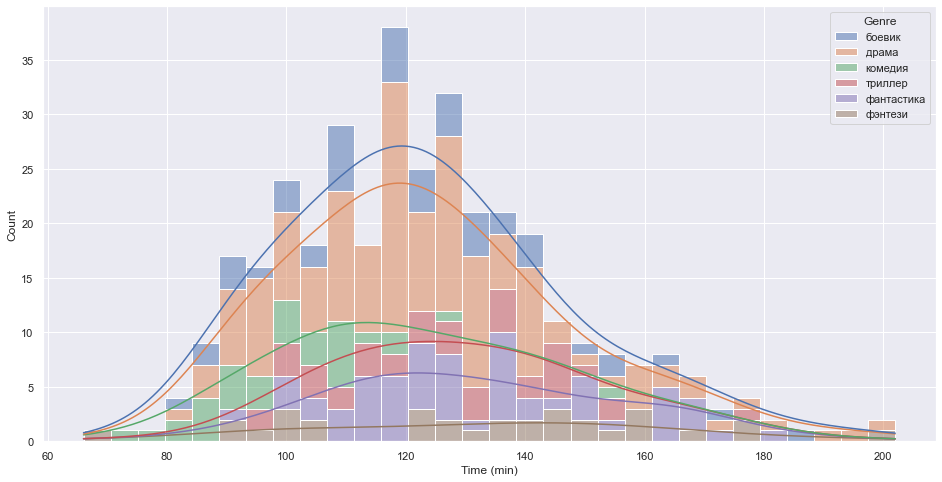

In [24]:
# Построим гистограммы распределения жанров фильмов от их продолжительности  
sns.histplot(data=df_pop, x='Time (min)', bins=30, hue="Genre", kde=True, multiple="stack")
plt.show()

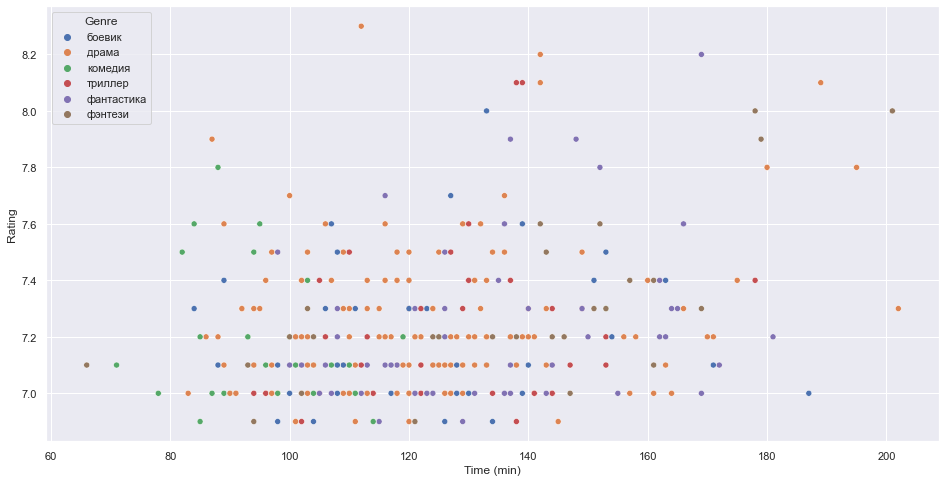

In [25]:
sns.scatterplot(data=df_pop, x="Time (min)", y="Rating", hue="Genre")
plt.show()

In [26]:
# Как видно нет чёткой зависимости рейтинга фильма от его продолжительности

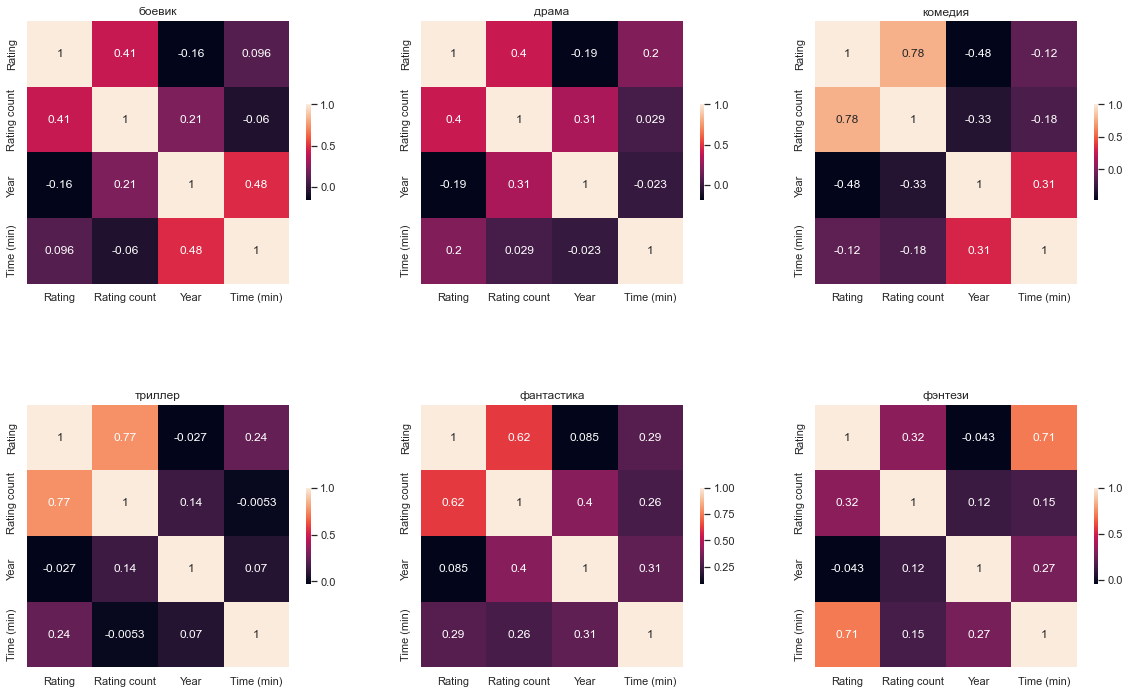

In [27]:
# Построим корреляционные матрицы
subset1 = df_pop[df_pop['Genre'] == 'боевик'].corr()
subset2 = df_pop[df_pop['Genre'] == 'драма'].corr()
subset3 = df_pop[df_pop['Genre'] == 'комедия'].corr()
subset4 = df_pop[df_pop['Genre'] == 'триллер'].corr()
subset5 = df_pop[df_pop['Genre'] == 'фантастика'].corr()
subset6 = df_pop[df_pop['Genre'] == 'фэнтези'].corr()

fig = plt.figure(figsize = (20, 20)) # width x height
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)

sns.heatmap(data=subset1, ax=ax1, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12}).set_title('боевик')
sns.heatmap(data=subset2, ax=ax2, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12}).set_title('драма')
sns.heatmap(data=subset3, ax=ax3, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12}).set_title('комедия')
sns.heatmap(data=subset4, ax=ax4, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12}).set_title('триллер')
sns.heatmap(data=subset5, ax=ax5, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12}).set_title('фантастика')
sns.heatmap(data=subset6, ax=ax6, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12}).set_title('фэнтези')
plt.show()

In [28]:
# Как видно что у всех жанров значения в корреляционных матрицах отличаются,
# поэтому было бы неправильно исследовать их как сумму.
# Выберем в качестве исследуемого объекта жанр в котором наибольшее количесвто наблюдений (драма).

In [29]:
df_drama = df[df['Genre'] == 'драма'].copy()
df_drama.drop(['Genre'], axis=1, inplace=True)
df_drama.reset_index(drop=True, inplace=True)
df_drama.head(5)

,Name,Rating,Rating count,Link,Country,Director,Year,Time (min)
0,1+1,8.3,566951,https://www.kinopoisk.ru/film/535341/,Франция,Оливье Накаш,2011,112
1,Побег из Шоушенка,8.2,84518,https://www.kinopoisk.ru/film/326/,США,Фрэнк Дарабонт,1994,142
2,Зеленая миля,8.1,87483,https://www.kinopoisk.ru/film/435/,США,Фрэнк Дарабонт,1999,189
3,Форрест Гамп,8.1,74188,https://www.kinopoisk.ru/film/448/,США,Роберт Земекис,1994,142
4,Достучаться до небес,7.9,130968,https://www.kinopoisk.ru/film/32898/,Германия,Томас Ян,1997,87


In [31]:
df_drama.describe()

,Rating,Rating count,Year,Time (min)
count,147.000000,147.000000,147.000000,147.000000
mean,7.236054,66210.734694,2005.836735,122.687075
std,0.256943,82797.306062,14.082458,22.491948
min,6.900000,5350.000000,1956.000000,83.000000
25%,7.100000,20892.000000,1998.500000,109.000000
50%,7.200000,36097.000000,2009.000000,120.000000
75%,7.350000,83148.500000,2017.000000,133.000000
max,8.300000,566951.000000,2024.000000,202.000000


In [32]:
# Удалим выборсы
df_drama = df_drama[df_drama['Year'] > 1970]
df_drama = df_drama[df_drama['Rating count'] < 180000]
df_drama = df_drama[df_drama['Time (min)'] < 170]
df_drama = df_drama[df_drama['Rating'] < 8]

In [33]:
df_drama.describe()

,Rating,Rating count,Year,Time (min)
count,128.000000,128.000000,128.000000,128.000000
mean,7.196875,49292.578125,2006.921875,119.281250
std,0.192349,37336.022777,12.137408,17.601422
min,6.900000,5350.000000,1972.000000,83.000000
25%,7.075000,20648.750000,2000.000000,109.000000
50%,7.200000,35076.000000,2009.500000,120.000000
75%,7.300000,67871.250000,2016.250000,129.250000
max,7.900000,173282.000000,2023.000000,166.000000


In [34]:
# Нулевая гипотеза (H0): Нет взаимосвязи между Rating и Rating count

In [35]:
X = df_drama[['Rating count', 'Year', 'Time (min)']]
Y = df_drama['Rating']
 
X = sm.add_constant(X, prepend=False)
model = OLS(Y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     34.02
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           4.11e-16
Time:                        19:10:52   Log-Likelihood:                 68.310
No. Observations:                 128   AIC:                            -128.6
Df Residuals:                     124   BIC:                            -117.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Rating count  3.556e-06   3.67e-07      9.681   

In [36]:
# Отметим, что все pvalue < 0.05, поэтому данные переменные нужны.
# Но у нас малый коэффициент детерминации, что говорит нам о том что наши переменные не плохо объясняют модель

In [37]:
X = df_drama[['Rating count']]
Y = df_drama['Rating']
 
X = sm.add_constant(X, prepend=False)
 
model = OLS(Y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     49.68
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           1.05e-10
Time:                        19:10:52   Log-Likelihood:                 51.153
No. Observations:                 128   AIC:                            -98.31
Df Residuals:                     126   BIC:                            -92.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Rating count   2.74e-06   3.89e-07      7.049   

In [38]:
# Коэффициент детерминации (R-squared) упал, что может означать Year и Time (min) нужны

In [39]:
X = df_drama[['Rating count', 'Year', 'Time (min)']]
Y = df_drama['Rating']
 
X = sm.add_constant(X, prepend=False)
model = OLS(Y, X)
res = model.fit()
print(res.summary())
 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
 
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     34.02
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           4.11e-16
Time:                        19:10:52   Log-Likelihood:                 68.310
No. Observations:                 128   AIC:                            -128.6
Df Residuals:                     124   BIC:                            -117.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Rating count  3.556e-06   3.67e-07      9.681   

In [40]:
# Мультиколлиниарности не наблюдается так как значения VIF < 4 

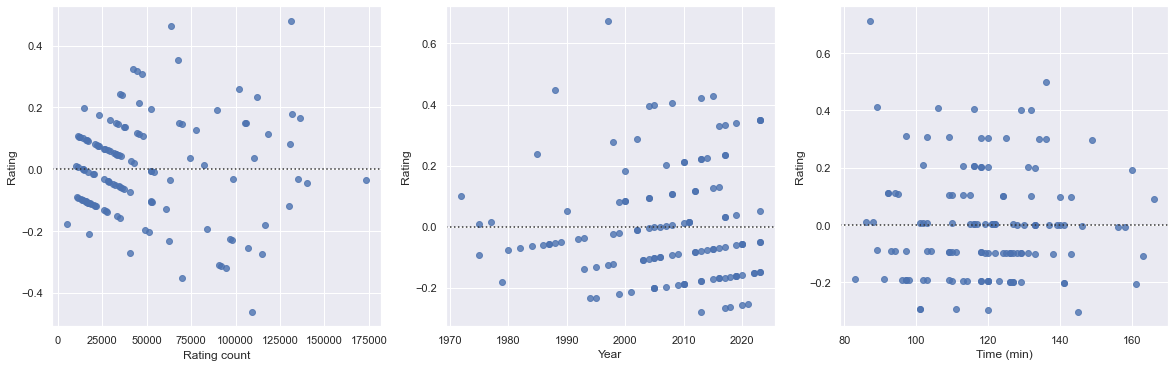

In [41]:
fig = plt.figure(figsize = (20, 20)) # width x height
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)

sns.residplot(x='Rating count', y='Rating', data=df_drama, ax=ax1) 
sns.residplot(x='Year',         y='Rating', data=df_drama, ax=ax2) 
sns.residplot(x='Time (min)',   y='Rating', data=df_drama, ax=ax3)
plt.show()

In [42]:
# Прослеживается некая гомоскедотичность, хотя не очень выраженная

In [43]:
# Итак, предскажем оценку пользователей на сайте Кинопоиск со следующими параметрами
# Rating count = 200 000
# Year = 2024
# Time = 120

In [45]:
res.predict([200_000, 2024, 120, 1])

array([7.61396646])